In [184]:
%matplotlib inline

In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold

plt.style.use('seaborn-v0_8-talk')
plt.rcParams['figure.figsize'] = (12,8)

font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

In [186]:
df_train = pd.read_csv("Train.csv")
df_test = pd.read_csv("Test.csv")
df_train.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,0,2011-1,560,NaN,2,59,3,0,30.0,1.0,...,0,0,0,0,0,0,0,0,0,4510000
1,1,2011-1,667,NaN,10,50,2,1,25.0,NaN,...,0,0,0,0,0,0,0,0,0,13231000
2,2,2011-1,90,0.0,1,48,2,0,25.0,0.0,...,0,0,0,0,0,0,0,0,0,2008000
3,3,2011-1,94,1.0,3,62,3,1,30.0,NaN,...,0,0,0,0,0,0,0,0,0,12680000
4,4,2011-1,232,0.0,3,60,3,0,25.0,NaN,...,0,0,0,0,0,0,0,0,0,3335000


In [187]:
X_train = df_train.iloc[:, np.arange(0, 24)]
Y_train = df_train['price']
X_test = df_test
X_test.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,100000,2012-3,459,NaN,1,60,3,1,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,100001,2012-3,344,1.0,10,52,2,1,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,100002,2012-3,585,0.0,4,54,3,0,30.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,100003,2012-3,494,NaN,2,52,2,1,25.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,100004,2012-3,622,1.0,9,60,3,1,15.0,NaN,...,0,0,0,0,0,0,0,0,0,0


### Узнаем, в каких столбцах есть пропуски

In [188]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          100000 non-null  int64  
 1   date        100000 non-null  object 
 2   street_id   100000 non-null  int64  
 3   build_tech  70265 non-null   float64
 4   floor       100000 non-null  int64  
 5   area        100000 non-null  int64  
 6   rooms       100000 non-null  int64  
 7   balcon      100000 non-null  int64  
 8   metro_dist  95104 non-null   float64
 9   g_lift      70008 non-null   float64
 10  n_photos    100000 non-null  int64  
 11  kw1         100000 non-null  int64  
 12  kw2         100000 non-null  int64  
 13  kw3         100000 non-null  int64  
 14  kw4         100000 non-null  int64  
 15  kw5         100000 non-null  int64  
 16  kw6         100000 non-null  int64  
 17  kw7         100000 non-null  int64  
 18  kw8         100000 non-null  int64  
 19  kw9

In [189]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          100000 non-null  int64  
 1   date        100000 non-null  object 
 2   street_id   100000 non-null  int64  
 3   build_tech  69980 non-null   float64
 4   floor       100000 non-null  int64  
 5   area        100000 non-null  int64  
 6   rooms       100000 non-null  int64  
 7   balcon      100000 non-null  int64  
 8   metro_dist  94883 non-null   float64
 9   g_lift      70186 non-null   float64
 10  n_photos    100000 non-null  int64  
 11  kw1         100000 non-null  int64  
 12  kw2         100000 non-null  int64  
 13  kw3         100000 non-null  int64  
 14  kw4         100000 non-null  int64  
 15  kw5         100000 non-null  int64  
 16  kw6         100000 non-null  int64  
 17  kw7         100000 non-null  int64  
 18  kw8         100000 non-null  int64  
 19  kw9

In [190]:
X_train["build_tech"].unique()

array([nan,  0.,  1.,  2.])

In [191]:
X_train["metro_dist"].unique()

array([30., 25., 20., 15., 10., nan,  0.,  5.])

### Заполним столбцы с пропущенными данными.

In [192]:
def df_fill_missed(df):
    df.loc[:, "g_lift"] = df.groupby("floor")["g_lift"].transform(lambda s: s.fillna(s.mode().iloc[0]))
    df.loc[:, "build_tech"] = df["build_tech"].transform(lambda s: s.fillna(s.mean()))
    df.loc[:, "metro_dist"] = df.groupby("street_id")["metro_dist"].transform(lambda s: s.fillna(s.mean()))
    return df

In [193]:
X_train = df_fill_missed(X_train)
X_test = df_fill_missed(X_test)
X_train.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,0,2011-1,560,0.529837,2,59,3,0,30.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,2011-1,667,0.529837,10,50,2,1,25.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,2,2011-1,90,0.000000,1,48,2,0,25.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,3,2011-1,94,1.000000,3,62,3,1,30.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,4,2011-1,232,0.000000,3,60,3,0,25.0,1.0,...,0,0,0,0,0,0,0,0,0,0


### Переведём даты в числовой формат

In [194]:
def df_transform_date(df):
    dt = pd.to_datetime(df["date"], format="%Y-%m")
    uniq = dt.sort_values().unique()
    mp = {d: i for i, d in enumerate(uniq)}
    df.loc[:, "date"] = dt.map(mp)
    return df

In [195]:
X_train = df_transform_date(X_train)
X_test = df_transform_date(X_test)
X_train.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,0,0,560,0.529837,2,59,3,0,30.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,667,0.529837,10,50,2,1,25.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,90,0.000000,1,48,2,0,25.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,94,1.000000,3,62,3,1,30.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,232,0.000000,3,60,3,0,25.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [196]:
cols = [
    'date', 'street_id', 'build_tech', 'floor', 'area', 'rooms',
    'balcon', 'metro_dist', 'g_lift', 'n_photos',
]
X_train_corr_matrix = X_train[cols].corr()
X_test_corr_matrix = X_test[cols].corr()

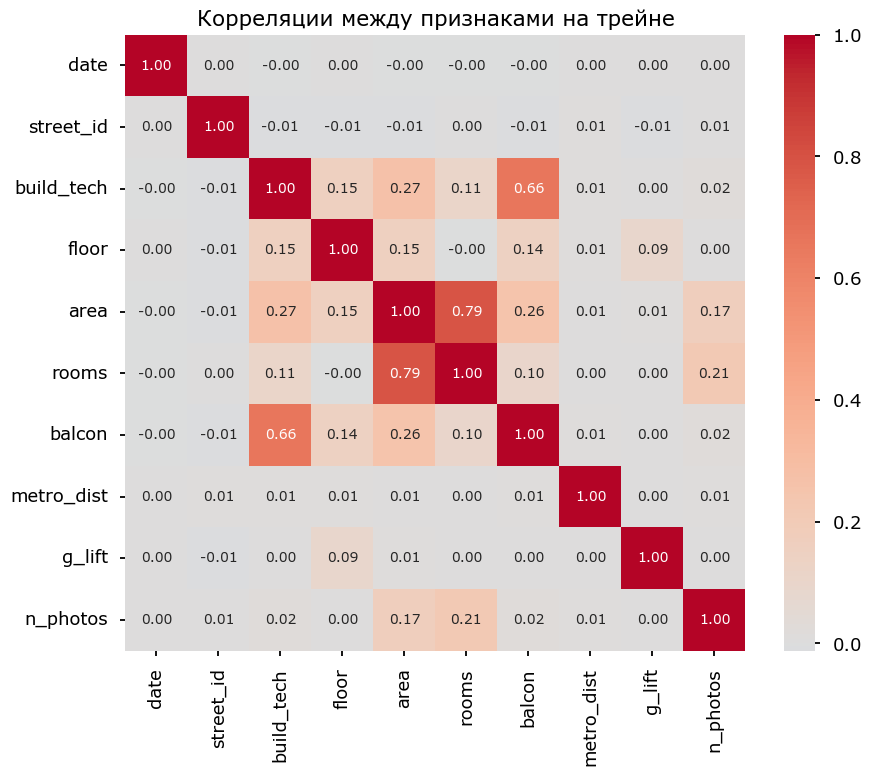

In [197]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(X_train_corr_matrix, 
            annot=True,
            fmt=".2f", 
            cmap="coolwarm", 
            center=0)
plt.title("Корреляции между признаками на трейне")
plt.show()

### Анализ корреляции признаков

area и rooms сильно коррелируют друг с другом => сделаем отдельный признак area_per_room \
аналогично объединим build_tech, balcon_area

In [198]:
def df_create_new_features(df):
    df['area_per_room'] = df['area'] / df['rooms']
    df['build_tech_balcon'] = df['balcon'] * df['build_tech']
    df['build_tech_balcon_area'] = df['build_tech_balcon'] * df['area']
    return df

In [199]:
df_corr = X_train.copy()
df_corr['price'] = Y_train.values

corr_with_target = df_corr.corr()['price'].drop('price')
corr_with_target.abs().sort_values(ascending=False)

area          0.662661
rooms         0.377233
build_tech    0.314310
balcon        0.292242
floor         0.201177
n_photos      0.189277
metro_dist    0.090806
date          0.083234
kw10          0.082532
kw2           0.065215
id            0.057665
kw3           0.052641
kw11          0.045092
kw13          0.032336
kw12          0.031372
kw4           0.025064
street_id     0.023578
kw1           0.015946
kw5           0.015622
g_lift        0.015190
kw7           0.012987
kw6           0.012217
kw8           0.001841
kw9           0.000004
Name: price, dtype: float64

### Анализ корреляции с целевой переменной

Как и ожидалось, главным фактором стоимости квартиры является её площадь и кол-во комнат. Но немаловажным оказался и тип здания, 30% значений которого в исходном наборе данных были пропущены

In [200]:
X_train = df_create_new_features(X_train)
X_test = df_create_new_features(X_test)
X_train.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw7,kw8,kw9,kw10,kw11,kw12,kw13,area_per_room,build_tech_balcon,build_tech_balcon_area
0,0,0,560,0.529837,2,59,3,0,30.0,1.0,...,0,0,0,0,0,0,0,19.666667,0.000000,0.000000
1,1,0,667,0.529837,10,50,2,1,25.0,1.0,...,0,0,0,0,0,0,0,25.000000,0.529837,26.491852
2,2,0,90,0.000000,1,48,2,0,25.0,0.0,...,0,0,0,0,0,0,0,24.000000,0.000000,0.000000
3,3,0,94,1.000000,3,62,3,1,30.0,1.0,...,0,0,0,0,0,0,0,20.666667,1.000000,62.000000
4,4,0,232,0.000000,3,60,3,0,25.0,1.0,...,0,0,0,0,0,0,0,20.000000,0.000000,0.000000


### Добавим в train и test предсказания других моделей

Идея в том, что итоговая модель сможет опираться на эти предсказания, соотносить с целевой переменной, и улучшать итоговое предсказание

In [201]:
def df_add_ensemble_predicts(df, path_ensemble):
    ensemble_predicts = pd.read_csv(path_ensemble)
    pred1 = ensemble_predicts.columns[0]
    pred2 = ensemble_predicts.columns[1]
    df[pred1] = ensemble_predicts[pred1]
    df[pred2] = ensemble_predicts[pred2]
    return df

In [202]:
X_train = df_add_ensemble_predicts(X_train, 'train_ensemble_predicts.csv')
X_test = df_add_ensemble_predicts(X_test, 'test_ensemble_predicts.csv')
X_train.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw9,kw10,kw11,kw12,kw13,area_per_room,build_tech_balcon,build_tech_balcon_area,CatBoostRegressor_predict,RobustScaler_CatBoostRegressor_predict
0,0,0,560,0.529837,2,59,3,0,30.0,1.0,...,0,0,0,0,0,19.666667,0.000000,0.000000,4.440805e+06,4.301709e+06
1,1,0,667,0.529837,10,50,2,1,25.0,1.0,...,0,0,0,0,0,25.000000,0.529837,26.491852,1.159053e+07,1.299189e+07
2,2,0,90,0.000000,1,48,2,0,25.0,0.0,...,0,0,0,0,0,24.000000,0.000000,0.000000,2.100388e+06,2.053757e+06
3,3,0,94,1.000000,3,62,3,1,30.0,1.0,...,0,0,0,0,0,20.666667,1.000000,62.000000,1.844535e+07,1.465414e+07
4,4,0,232,0.000000,3,60,3,0,25.0,1.0,...,0,0,0,0,0,20.000000,0.000000,0.000000,4.012178e+06,4.306491e+06


In [203]:
X_test.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw9,kw10,kw11,kw12,kw13,area_per_room,build_tech_balcon,build_tech_balcon_area,CatBoostRegressor_predict,RobustScaler_CatBoostRegressor_predict
0,100000,0,459,0.532452,1,60,3,1,30.000000,0.0,...,0,0,0,0,0,20.0,0.532452,31.947128,7.222853e+06,7.217352e+06
1,100001,0,344,1.000000,10,52,2,1,28.964286,1.0,...,0,0,0,0,0,26.0,1.000000,52.000000,3.536005e+06,3.731788e+06
2,100002,0,585,0.000000,4,54,3,0,30.000000,0.0,...,0,0,0,0,0,18.0,0.000000,0.000000,3.099441e+06,3.418726e+06
3,100003,0,494,0.532452,2,52,2,1,25.000000,1.0,...,0,0,0,0,0,26.0,0.532452,27.687511,2.546569e+06,2.489952e+06
4,100004,0,622,1.000000,9,60,3,1,15.000000,1.0,...,0,0,0,0,0,20.0,1.000000,60.000000,5.021386e+06,5.657773e+06


In [204]:
categorical_features = ['street_id', 'balcon', 'rooms']
numeric_features = [
    'date', 'build_tech', 'floor',
    'area', 'metro_dist',
    'area_per_room', 'build_tech_balcon', 
    'build_tech_balcon_area', 'CatBoostRegressor_predict',
    'RobustScaler_CatBoostRegressor_predict'
]

In [205]:
def df_normalize_train_test(X_train, X_test, categorical_features, numeric_features):
    scaler = StandardScaler()
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    
    X_train_num = scaler.fit_transform(X_train[numeric_features])
    X_train_cat = ohe.fit_transform(X_train[categorical_features])
    
    X_test_num = scaler.transform(X_test[numeric_features])
    X_test_cat = ohe.transform(X_test[categorical_features])
    
    X_train_union = np.hstack([X_train_num, X_train_cat])
    X_test_union = np.hstack([X_test_num, X_test_cat])
    
    all_cols = numeric_features + list(ohe.get_feature_names_out(categorical_features))
    
    X_train_normalized = pd.DataFrame(X_train_union, columns=all_cols, index=X_train.index)
    X_test_normalized = pd.DataFrame(X_test_union, columns=all_cols, index=X_test.index)
    
    return X_train_normalized, X_test_normalized

In [206]:
X_train_scaled, X_test_scaled = df_normalize_train_test(
    X_train, X_test, categorical_features, numeric_features
)

X_train_scaled

,date,build_tech,floor,area,metro_dist,area_per_room,build_tech_balcon,build_tech_balcon_area,CatBoostRegressor_predict,RobustScaler_CatBoostRegressor_predict,...,street_id_671,balcon_0,balcon_1,balcon_2,rooms_1,rooms_2,rooms_3,rooms_4,rooms_5,rooms_6
0,-1.637079,0.000000,-0.836679,0.379182,0.962560,-1.048311,-0.561325,-0.467922,-0.195033,-0.241705,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-1.637079,0.000000,1.211695,-0.126651,0.349113,-0.237077,0.213205,0.072249,1.581198,1.983765,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-1.637079,-1.101875,-1.092725,-0.239059,0.349113,-0.389183,-0.561325,-0.467922,-0.776471,-0.817383,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-1.637079,0.977774,-0.580632,0.547794,0.962560,-0.896205,0.900501,0.796262,3.284163,2.409450,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.637079,-1.101875,-0.580632,0.435386,0.349113,-0.997609,-0.561325,-0.467922,-0.301518,-0.240480,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.063458,-1.101875,-0.068539,-1.250726,0.962560,0.523455,-0.561325,-0.467922,-0.911459,-0.924429,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
99996,1.063458,-1.101875,-0.324585,-1.025911,0.962560,1.131881,-0.561325,-0.467922,-0.390325,-0.449955,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
99997,1.063458,0.000000,-0.580632,-0.014244,-2.104676,-0.084970,-0.561325,-0.467922,0.173462,0.157510,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
99998,1.063458,0.977774,-0.580632,7.236039,-2.104676,1.466515,0.900501,3.222681,4.656851,5.280049,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [207]:
X_test_scaled.columns

Index(['date', 'build_tech', 'floor', 'area', 'metro_dist', 'area_per_room',
       'build_tech_balcon', 'build_tech_balcon_area',
       'CatBoostRegressor_predict', 'RobustScaler_CatBoostRegressor_predict',
       ...
       'street_id_671', 'balcon_0', 'balcon_1', 'balcon_2', 'rooms_1',
       'rooms_2', 'rooms_3', 'rooms_4', 'rooms_5', 'rooms_6'],
      dtype='object', length=691)

In [208]:
Y_train

0         4510000
1        13231000
2         2008000
3        12680000
4         3335000
           ...   
99995     1697000
99996     3620000
99997     6712000
99998    20835000
99999     2909000
Name: price, Length: 100000, dtype: int64

In [209]:
catboost_model = CatBoostRegressor(
    loss_function='MAE',
    silent=True,
    random_seed=42,
    depth=5,
    iterations=1500,
    l2_leaf_reg=8,
    learning_rate=0.5
)

catboost_model.fit(X_train_scaled, Y_train)

In [210]:
Y_pred = catboost_model.predict(X_test_scaled)
Y_pred

array([6823007.33291642, 3703881.11046851, 3123839.71642062, ...,
       4586227.36938863, 3659360.41480121, 5299768.66199459])

In [211]:
df_res = pd.read_csv('SampleSubmission.csv')
df_res['price'] = Y_pred
df_res.head()

,id,price
0,100000,6.823007e+06
1,100001,3.703881e+06
2,100002,3.123840e+06
3,100003,2.588744e+06
4,100004,5.579143e+06


In [212]:
df_res.to_csv("submission.csv", index=False)

### Итоговый MAE: 1 090 000